# MCT4052 Workshop 5e: MIDI Files + LDA + SVM Classifier v2

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

The notebooks Workshop 5b to 5h integrates a stage of dimensionality reduction with different type of machine learning technique (classification, regression, clustering) on audio or MIDI data. The machine learning techniques included in this set of examples are those from previous workshops.

In [1]:
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import sklearn
import pretty_midi

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:

def extract_features(filename):
    
    pm = pretty_midi.PrettyMIDI(filename)
    
    output = pm.get_pitch_class_transition_matrix().flatten()
    
    return output


filenames = os.listdir('./data/examples7')
num_of_features = len(extract_features('./data/examples7/'+filenames[0]))
features = np.zeros((len(filenames),num_of_features)) 
labels = np.zeros((len(filenames))) 
classes = ['beethoven','chp','mz', 'schu'] 

for i in range(len(filenames)):
    print('processing',filenames[i])
    features[i,:] = extract_features('./data/examples7/'+filenames[i])
    if filenames[i].find(classes[0]) != -1:
        labels[i] = 0
    elif filenames[i].find(classes[1]) != -1:
        labels[i] = 1
    elif filenames[i].find(classes[2]) != -1:
        labels[i] = 2
    elif filenames[i].find(classes[3]) != -1:
        labels[i] = 3
        
print('Done!')

processing schumm-1.mid
processing chpn_op23.mid
processing chpn_op7_2.mid
processing beethoven_opus90_2.mid
processing chpn-p18.mid
processing schumm-2.mid
processing schub_d960_4.mid
processing chpn_op7_1.mid
processing beethoven_opus90_1.mid
processing schub_d960_1.mid
processing chpn-p23.mid
processing schumm-6.mid
processing mz_570_1.mid
processing mz_570_2.mid
processing schuim-4.mid
processing beethoven_opus10_2.mid
processing chpn_op33_4.mid
processing beethoven_opus10_3.mid
processing chpn_op35_1.mid
processing schuim-3.mid
processing beethoven_opus10_1.mid
processing chpn_op25_e3.mid
processing schuim-2.mid
processing mz_545_1.mid
processing mz_332_3.mid
processing mz_330_1.mid
processing chpn_op10_e12.mid
processing mz_330_2.mid
processing schubert_D935_4.mid
processing mz_330_3.mid
processing mz_332_1.mid
processing mz_545_3.mid
processing beethoven_les_adieux_3.mid
processing chpn_op10_e01.mid
processing schubert_D935_1.mid
processing chpn_op66.mid
processing schub_d760_1.

In [3]:
#this step converts the labels from a numpy array to 
#a Pandas series, which allows backtracing misclassified examples
#scikitlearn can handle features or labels also as Pandas formats
labels = pd.Series(labels)

In [4]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.3, random_state=17)

In [5]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

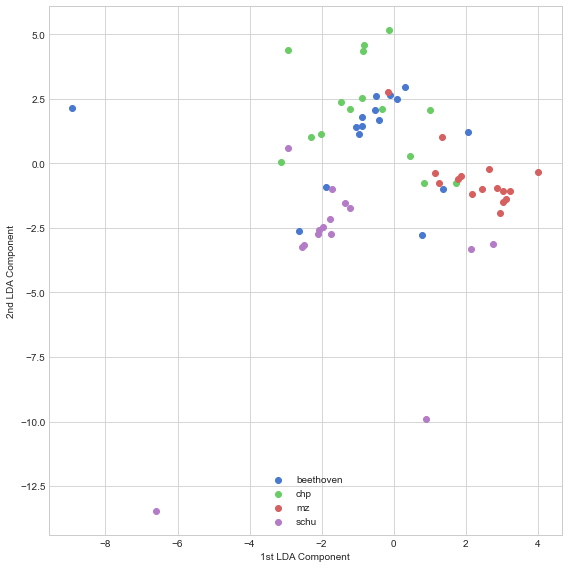

In [6]:
#Creating an instance of the LDA object, which is an object capable of learning and applying LDA from/to data.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#lda will keep a number of components equal to 2
lda = LinearDiscriminantAnalysis(n_components=2)


#This will learn LDA projection from train data
lda.fit(feat_train,lab_train)

#Now we project the data using LDA
projected_features_train = lda.transform(feat_train)
projected_features_test = lda.transform(feat_test)

#this is only for scatter plot purposes
projected_features = lda.transform(scaler.transform(features))


#Plot the distribution of the data according to the first two principle components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 8))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 0],
                    projected_features[labels==lab_val, 1],
                    label=lab_name)
    plt.xlabel('1st LDA Component')
    plt.ylabel('2nd LDA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [7]:
#Creating an instance of a SVM classifier
model_SVM = sklearn.svm.SVC(kernel='linear', C=1.0)

#training the model
model_SVM.fit(projected_features_train, lab_train)

#applying the the model on the test data (features)
lab_predict = model_SVM.predict(projected_features_test)


#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Number of mislabeled samples 9 out of 19
Accuracy: 0.5263157894736842


In [8]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

print(sklearn.metrics.confusion_matrix(lab_test, lab_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33         5
         1.0       0.67      0.67      0.67         6
         2.0       0.33      1.00      0.50         3
         3.0       0.67      0.40      0.50         5

    accuracy                           0.53        19
   macro avg       0.67      0.57      0.50        19
weighted avg       0.70      0.53      0.51        19

[[1 1 2 1]
 [0 4 2 0]
 [0 0 3 0]
 [0 1 2 2]]


In [9]:
#displaying names of misclassified files
results = lab_test == lab_predict
for index, value in results.items():
    if value == False:
        print(filenames[index])


chpn_op33_4.mid
beethoven_les_adieux_1.mid
chpn_op25_e3.mid
beethoven_hammerklavier_1.mid
schumm-1.mid
schubert_D935_4.mid
schub_d760_1.mid
beethoven_opus22_1.mid
beethoven_hammerklavier_3.mid
